# Comparison of different renewal processes inferred Rt profiles

In [1]:
# Import libraries
import numpy as np
import math
import branchpro
import scipy.stats
from branchpro.apps import ReproductionNumberPlot
import plotly.graph_objects as go
import pandas as pd
import stan
import arviz as az
import nest_asyncio
nest_asyncio.apply()

num_timepoints = 30 # number of days for incidence data
num_categories = 2

In [2]:
# # Read contact matrix
# cm_file = 'UK'
# path = os.path.join('../data_library/contact_matrix', '{}.csv'.format(cm_file))
# contact_matrix = pd.read_csv(path, header=None)

# # Read serial interval
# si_file = 'si-epinow'
# path = os.path.join('../data_library/serial_interval', '{}.csv'.format(si_file))
# serial_interval = pd.read_csv(path, header=None)
# serial_interval = serial_interval.fillna(0)
# serial_intervals = serial_interval.values.T

# # Read transmissibility vector
# trans_file = 'UK'
# path = os.path.join('../data_library/transmissibility', '{}.csv'.format(trans_file))
# transmissibility = pd.read_csv(path, header=None)

In [3]:
# # Read Ontario data
# path = os.path.join('../data_library/covid_ontario/ON.csv')
# data = pd.read_csv(path)[:51]

## Parameterize example branching process model with disagregated data

In [4]:
# Build the serial interval w_s
ws_mean = 2.6
ws_var = 1.5**2
theta = ws_var / ws_mean
k = ws_mean / theta
w_dist = scipy.stats.gamma(k, scale=theta)
disc_w = w_dist.pdf(np.arange(num_timepoints))

# Simulate incidence data
initial_r = 3
serial_interval = disc_w

# contact_matrix = contact_matrix
contact_matrix = np.array([[1, 0.5], [0.3, 0.4]])
# contact_matrix = 1 * np.ones((2, 2))

transmissibility = [0.5, 1.2]
# transmissibility = [1.5, 1.5]

m = branchpro.MultiCatPoissonBranchProModel(
    initial_r, serial_interval, num_categories, contact_matrix, transmissibility)
new_rs = [3, 0.5]          # sequence of R_0 numbers
start_times = [0, 15]      # days at which each R_0 period begins
m.set_r_profile(new_rs, start_times)
parameters = [50, 50] # initial number of cases
times = np.arange(num_timepoints)

desagg_cases = m.simulate(parameters, times)
agg_cases = np.sum(desagg_cases, axis=1)

print(desagg_cases)

[[  50.   50.]
 [   0.    0.]
 [  38.   36.]
 [  51.   34.]
 [  76.   28.]
 [  97.   40.]
 [ 112.   54.]
 [ 155.   78.]
 [ 209.   85.]
 [ 277.  131.]
 [ 335.  136.]
 [ 412.  203.]
 [ 559.  255.]
 [ 717.  311.]
 [ 850.  447.]
 [1122.  570.]
 [ 246.  130.]
 [ 295.  168.]
 [ 270.  152.]
 [ 221.  118.]
 [ 172.   67.]
 [ 142.   69.]
 [ 121.   68.]
 [  97.   53.]
 [  67.   39.]
 [  58.   27.]
 [  47.   30.]
 [  30.   21.]
 [  19.   17.]
 [  23.    9.]]


## Plot agreggated local incidence numbers

In [5]:
# Plot (bar chart cases each day)
fig = go.Figure()

# Plot of incidences
fig.add_trace(
    go.Bar(
        x=times,
        y=agg_cases,
        name='Incidences'
    )
)

# Add axis labels
fig.update_layout(
    xaxis_title='Time (days)',
    yaxis_title='New cases'
)

fig.show()

## R_t inference using STAN

In [6]:
# Same inference, but using the PoissonBranchProPosterior
tau = 6
R_t_start = tau+1
a = 1
b = 1/5

phi_mean = 0.5
phi_var = 10**(-0)
phi_rate = phi_var / phi_mean
phi_shape = phi_mean / phi_rate

# Naive correction for reproduction number per individual
# i.e. no variation in contacts and transmissibility between different categories
N_corr = num_categories * (np.sum(np.matmul(contact_matrix, transmissibility))/np.sum(contact_matrix))

# True correction - only available when we have desaggreagted case data
T_corr = np.empty(num_timepoints - R_t_start)

for _, t in enumerate(np.arange(R_t_start, num_timepoints)):
    T_corr[_] = np.sum(np.matmul(
                    contact_matrix,
                    np.multiply(
                        transmissibility,
                        m._effective_no_infectives(t, desagg_cases)
                    )))/ np.sum(m._effective_no_infectives(t, desagg_cases))

In [7]:
# Transform our incidence data into pandas dataframes
multicat_inc_data_matrix = {'Time': np.arange(num_timepoints)}

for _ in range(num_categories):
    multicat_inc_data_matrix['Incidence Number Cat {}'.format(_+1)] = \
        desagg_cases[:, _]

multicat_inc_data = pd.DataFrame(multicat_inc_data_matrix)

# Transform our incidence data into pandas dataframes
inc_data = pd.DataFrame(
    {
        'Time': np.arange(num_timepoints),
        'Incidence Number': agg_cases
    }
)

L1 = len(np.arange(R_t_start, start_times[1]+1))
L2 = len(np.arange(start_times[1]+1, num_timepoints))

ground_truth = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'R_t': L1*[3] + L2*[0.5]
})

### Desaggregated data + Poisson Branching process with multiple categories

In [8]:
multicat_model = """
functions {
    real normalizing_const (array [] real aSI) {
        return sum(aSI);
    }
    real effective_no_infectives (
        int N, int S, int n, int i, int t, array [,] real aI, array [] real aSI,
        array [,] real C, array [] real transm) {
            real mean;

            mean = 0;
            for(j in 1:n){
                if(t > S) {
                    mean += C[i,j] * transm[j] * (
                        dot_product(aI[(t-S):(t-1), j], aSI) /
                        normalizing_const(aSI));
                }
                else {
                    mean += C[i,j] * transm[j] * (
                        dot_product(aI[:(t-1), j], aSI[(S-t+2):]) /
                        normalizing_const(aSI));
                }
            }
            return mean;
    }
}
data {
    int N; // number of days
    int S; // length serial interval
    int n; // number of categories
    array [n, n] real C; // contact matrix
    array [n] real transm; // transmissibility vector
    array [N, n] int I; // local incidences for N days
    int tau; // sliding window
    array [S] real revSI; // reversed serial interval
    real a; // prior shape parameter
    real b; // prior rate parameter
}
parameters {
    array [N-tau-1] real<lower=0> R; // vector of R numbers
}
model {
    for(t in (tau+1):(N-1)) {
        for (i in 1:n){
            for(k in (t-tau+1):(t+1)) {
                if (effective_no_infectives(N, S, n, i, k, I, revSI, C, transm) != 0) {
                    I[k, i] ~ poisson (
                        R[t-tau] * effective_no_infectives(
                            N, S, n, i, k, I, revSI, C, transm)); // likelihood
                        }
            }
        }
    }
    for(t in 1:(N-tau-1)) {
        R[t] ~ gamma (a, b); // prior of R
    }
}
"""

multicat_data = {
    'N': num_timepoints,
    'S': len(serial_interval),
    'n': num_categories,
    'C': contact_matrix,
    'transm': transmissibility,
    'I': desagg_cases.astype(np.integer).tolist(),
    'tau': tau,
    'revSI': serial_interval.tolist()[::-1],
    'a': a,
    'b': b}

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_10465/2312879604.py:66: DeprecationWarning:

Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.



In [9]:
posterior = stan.build(
    multicat_model, data=multicat_data, random_seed=10)

fit = posterior.sample(
    num_chains=3, num_samples=1000)

samples = az.from_pystan(
    fit,
    observed_data='I',
    coords={'observation': list(range(num_timepoints)),
            'covariate': [
                '{}'.format(_)
                for _ in range(num_timepoints - R_t_start)]
            },
    dims={
        'I': ['observation'],
        'R': ['covariate']
        })

az.summary(samples)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/6000)
Sampling:   0% (2/6000)
Sampling:   0% (3/6000)
Sampling:   2% (102/6000)
Sampling:   3% (201/6000)
Sampling:   5% (300/6000)
Sampling:   7% (400/6000)
Sampling:   8% (500/6000)
Sampling:  10% (600/6000)
Sampling:  12% (700/6000)
Sampling:  13% (800/6000)
Sampling:  15% (900/6000)
Sampling:  17% (1000/6000)
Sampling:  18% (1100/6000)
Sampling:  20% (1200/6000)
Sampling:  22% (1300/6000)
Sampling:  23% (1400/6000)
Sampling:  25% (1500/6000)
Sampling:  27% (1600/6000)
Sampling:  28% (1700/6000)
Sampling:  30% (1800/6000)
Sampling:  32% (1900/6000)
Sampling:  33% (2000/6000)
Sampling:  35% (2100/6000)
Sampling:  37% (2200/6000)
Sampling:  38% (2300/6000)
Sampling:  40% (2400/6000)
Sampling:  42% (2500/6000)
Sampling:  43% (2600/6000)
Sampling:  45% (2700/6000)
Sampling:  47% (2801/6000)
Samp

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
R[0],3.013,0.110,2.793,3.208,0.001,0.001,8998.0,1779.0,1.0
R[1],3.030,0.090,2.875,3.213,0.001,0.001,6980.0,1980.0,1.0
R[2],3.074,0.082,2.934,3.231,0.001,0.001,6609.0,1881.0,1.0
R[3],3.024,0.069,2.896,3.158,0.001,0.001,6249.0,2271.0,1.0
R[4],2.981,0.062,2.861,3.093,0.001,0.001,7293.0,2221.0,1.0
R[5],2.986,0.055,2.878,3.082,0.001,0.000,8541.0,2406.0,1.0
R[6],2.993,0.047,2.898,3.076,0.001,0.000,6701.0,2273.0,1.0
R[7],2.967,0.042,2.890,3.045,0.001,0.000,6230.0,2287.0,1.0
R[8],2.961,0.037,2.898,3.036,0.000,0.000,6350.0,2115.0,1.0
R[9],2.293,0.028,2.241,2.346,0.000,0.000,7159.0,2100.0,1.0


array([[<AxesSubplot:title={'center':'R\n0'}>,
        <AxesSubplot:title={'center':'R\n0'}>],
       [<AxesSubplot:title={'center':'R\n1'}>,
        <AxesSubplot:title={'center':'R\n1'}>],
       [<AxesSubplot:title={'center':'R\n2'}>,
        <AxesSubplot:title={'center':'R\n2'}>],
       [<AxesSubplot:title={'center':'R\n3'}>,
        <AxesSubplot:title={'center':'R\n3'}>],
       [<AxesSubplot:title={'center':'R\n4'}>,
        <AxesSubplot:title={'center':'R\n4'}>],
       [<AxesSubplot:title={'center':'R\n5'}>,
        <AxesSubplot:title={'center':'R\n5'}>],
       [<AxesSubplot:title={'center':'R\n6'}>,
        <AxesSubplot:title={'center':'R\n6'}>],
       [<AxesSubplot:title={'center':'R\n7'}>,
        <AxesSubplot:title={'center':'R\n7'}>],
       [<AxesSubplot:title={'center':'R\n8'}>,
        <AxesSubplot:title={'center':'R\n8'}>],
       [<AxesSubplot:title={'center':'R\n9'}>,
        <AxesSubplot:title={'center':'R\n9'}>],
       [<AxesSubplot:title={'center':'R\n10'}>,
  

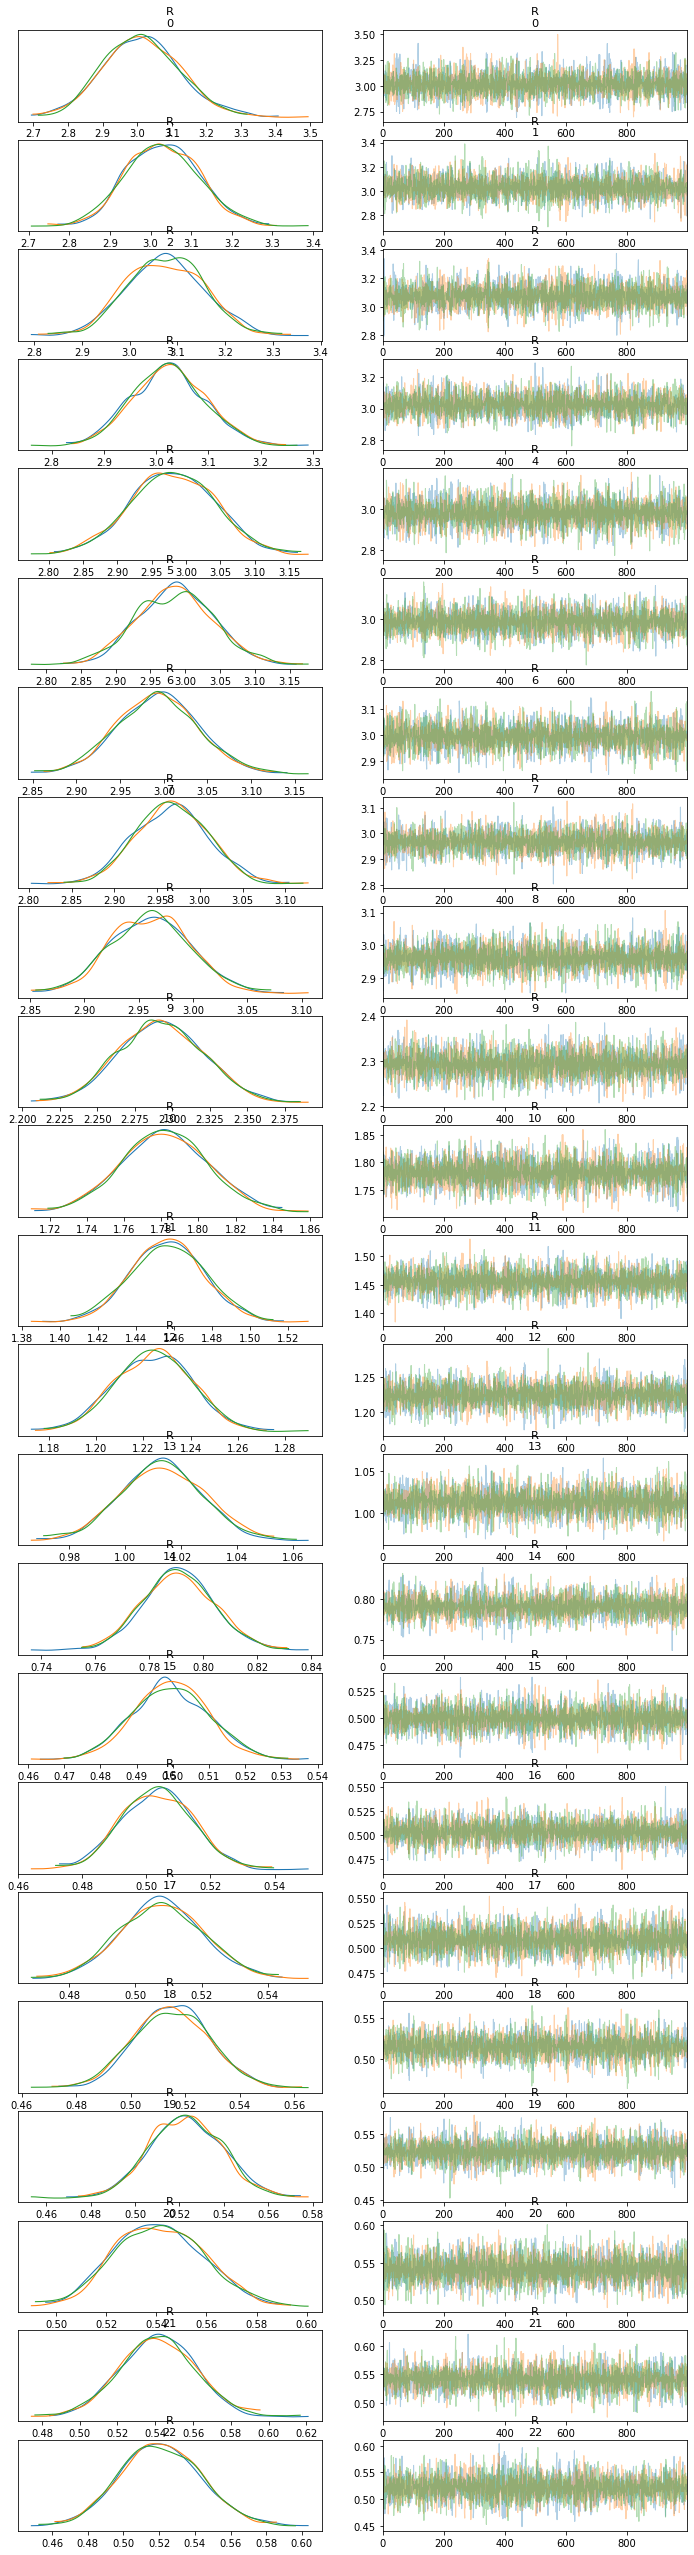

In [10]:
az.rcParams['plot.max_subplots'] = 2*(num_timepoints - R_t_start)

az.plot_trace(
    samples,
    var_names=('R'),
    filter_vars='like',
    compact=False)

In [11]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
chain_samples = fit._draws[7:, 500:, :]

# Evaluate the model for all parameter sets in the samples
n_param, n_sample, n_chains = chain_samples.shape

extended_samples = np.concatenate((
    chain_samples[:, :, 0],
    chain_samples[:, :, 1],
    chain_samples[:, :, 2]), axis=1)

thinning = max(1, int(n_sample * n_chains / 500))

multicat_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': np.mean(extended_samples[:, ::thinning], axis=1),
    'Lower bound CI': np.quantile(extended_samples[:, ::thinning], 0.025, axis=1),
    'Upper bound CI': np.quantile(extended_samples[:, ::thinning], 0.975, axis=1),
    'Central Probability': (L1+L2) * [0.95]
})

### Aggregated data + Poisson Branching process with multiple categories

In [12]:
agg_multicat_model = """
functions {
    real normalizing_const (array [] real aSI) {
        return sum(aSI);
    }
    real effective_no_infectives (
        int N, int S, int n, int t, array [] real aI, array [] real aSI,
        array [,] real C, array [] real transm, array [] vector ap) {
            real mean;

            mean = 0;
            for(i in 1:n){
                for(j in 1:n){
                    if(t > S) {
                        for(k in (t-S):(t-1)){
                            mean += C[i,j] * transm[j] * ap[k, j] * aI[k] * aSI[S-t+1+k] /
                                normalizing_const(aSI);
                        }
                    }
                    else {
                        for(k in 1:(t-1)){
                            mean += C[i,j] * transm[j] * ap[k, j] * aI[k] * aSI[S-t+1+k] /
                                normalizing_const(aSI);
                        }
                    }
                }
            }
            return mean;
    }
}
data {
    int N; // number of days
    int S; // length serial interval
    int n; // number of categories
    array [n, n] real C; // contact matrix
    array [n] real transm; // transmissibility vector
    array [N] int I; // local incidences for N days
    int tau; // sliding window
    array [S] real revSI; // reversed serial interval
    real a; // prior shape parameter
    real b; // prior rate parameter
}
parameters {
    array [N-tau-1] real<lower=0> R; // vector of R numbers
    simplex [n] p[N]; // vector of proportion
}
model {
    for(t in (tau+1):(N-1)) {
        for(k in (t-tau+1):(t+1)) {
            if (effective_no_infectives(N, S, n, k, I, revSI, C, transm, p) != 0) {
                I[k] ~ poisson (
                    R[t-tau] * effective_no_infectives(
                        N, S, n, k, I, revSI, C, transm, p)); // likelihood
                    }
        }
    }
    for(t in 1:(N-tau-1)) {
        R[t] ~ gamma (a, b); // prior of R
    }
    for(t in 1:N) {
        p[t] ~ dirichlet (rep_vector(1, n)); // prior for p
    }
}
"""

agg_multicat_data = {
    'N': num_timepoints,
    'S': len(serial_interval),
    'n': num_categories,
    'C': contact_matrix,
    'transm': transmissibility,
    'I': agg_cases.astype(np.integer).tolist(),
    'tau': tau,
    'revSI': serial_interval.tolist()[::-1],
    'a': a,
    'b': b}

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_10465/198546996.py:72: DeprecationWarning:

Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.



In [13]:
posterior = stan.build(
    agg_multicat_model, data=agg_multicat_data, random_seed=10)

fit = posterior.sample(
    num_chains=3, num_samples=1000)

samples = az.from_pystan(
    fit,
    observed_data='I',
    coords={'observation': list(range(num_timepoints)),
            'covariate': [
                '{}'.format(_)
                for _ in range(num_timepoints - R_t_start)]
            },
    dims={
        'I': ['observation'],
        'R': ['covariate'],
        })

az.summary(samples)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/httpstan_nzmyh6o_/model_pexo4ija.stan', line 45, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/httpstan_nzmyh6o_/model_pexo4ija.stan', line 50, column 12: A
    control flow statement depends on parameter(s): p.
Warning in '/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/httpstan_nzmyh6o_/model_pexo4ija.stan', line 21, column 24: A
    control flow statement inside function effective_no_infectives depends on
    argument t. At
    '/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/httpstan_nzmyh6o_/model_pexo4ija.stan',
    line 53, column 33 to column 34, the value of t depends on parameter(s):
    p.
Warn

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
R[0],2.406,0.094,2.241,2.595,0.001,0.001,6996.0,2401.0,1.0
R[1],2.375,0.076,2.228,2.517,0.001,0.001,5555.0,2118.0,1.0
R[2],2.367,0.068,2.243,2.495,0.001,0.001,6448.0,2312.0,1.0
R[3],2.292,0.057,2.185,2.395,0.001,0.000,7011.0,2190.0,1.0
R[4],2.227,0.047,2.139,2.314,0.001,0.000,6966.0,2086.0,1.0
...,...,...,...,...,...,...,...,...,...
"p[27, 1]",0.480,0.289,0.024,0.955,0.003,0.003,7575.0,1679.0,1.0
"p[28, 0]",0.504,0.291,0.048,0.986,0.004,0.003,6618.0,1818.0,1.0
"p[28, 1]",0.496,0.291,0.014,0.952,0.004,0.003,6618.0,1818.0,1.0
"p[29, 0]",0.504,0.295,0.039,0.979,0.003,0.003,7003.0,1672.0,1.0


array([[<AxesSubplot:title={'center':'R\n0'}>,
        <AxesSubplot:title={'center':'R\n0'}>],
       [<AxesSubplot:title={'center':'R\n1'}>,
        <AxesSubplot:title={'center':'R\n1'}>],
       [<AxesSubplot:title={'center':'R\n2'}>,
        <AxesSubplot:title={'center':'R\n2'}>],
       [<AxesSubplot:title={'center':'R\n3'}>,
        <AxesSubplot:title={'center':'R\n3'}>],
       [<AxesSubplot:title={'center':'R\n4'}>,
        <AxesSubplot:title={'center':'R\n4'}>],
       [<AxesSubplot:title={'center':'R\n5'}>,
        <AxesSubplot:title={'center':'R\n5'}>],
       [<AxesSubplot:title={'center':'R\n6'}>,
        <AxesSubplot:title={'center':'R\n6'}>],
       [<AxesSubplot:title={'center':'R\n7'}>,
        <AxesSubplot:title={'center':'R\n7'}>],
       [<AxesSubplot:title={'center':'R\n8'}>,
        <AxesSubplot:title={'center':'R\n8'}>],
       [<AxesSubplot:title={'center':'R\n9'}>,
        <AxesSubplot:title={'center':'R\n9'}>],
       [<AxesSubplot:title={'center':'R\n10'}>,
  

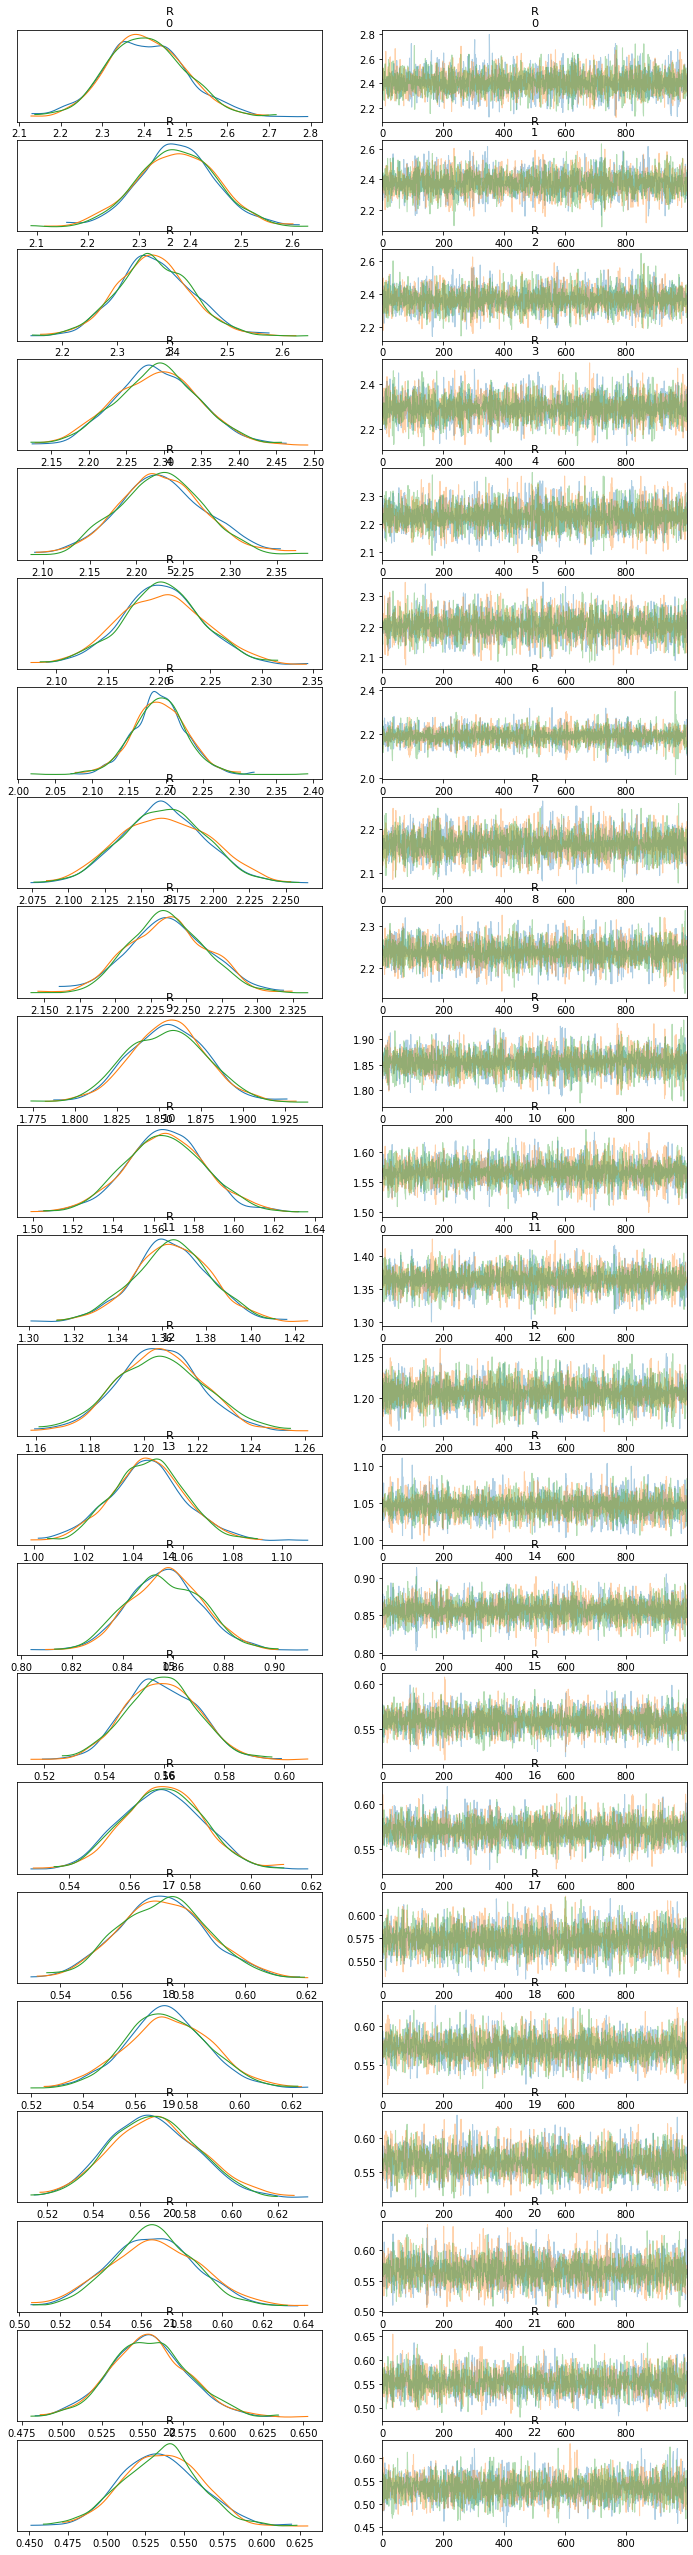

In [14]:
az.rcParams['plot.max_subplots'] = 2*(num_timepoints - R_t_start)

az.plot_trace(
    samples,
    var_names=('R'),
    filter_vars='like',
    compact=False)

In [15]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
chain_samples = fit._draws[7:(num_timepoints - R_t_start +7), 500:, :]

# Evaluate the model for all parameter sets in the samples
n_param, n_sample, n_chains = chain_samples.shape

extended_samples = np.concatenate((
    chain_samples[:, :, 0],
    chain_samples[:, :, 1],
    chain_samples[:, :, 2]), axis=1)

thinning = max(1, int(n_sample * n_chains / 500))

agg_multicat_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': np.mean(extended_samples[:, ::thinning], axis=1),
    'Lower bound CI': np.quantile(extended_samples[:, ::thinning], 0.025, axis=1),
    'Upper bound CI': np.quantile(extended_samples[:, ::thinning], 0.975, axis=1),
    'Central Probability': (L1+L2) * [0.95]
})

### Aggregated data + Poisson Branching process

In [16]:
poisson_model = """
functions {
    real normalizing_const (array [] real aSI) {
        return sum(aSI);
    }
    real effective_no_infectives (
        int N, int S, int t, array [] real aI, array [] real aSI) {
            real mean;
            if(t > S) {
                mean = (
                    dot_product(aI[(t-S):(t-1)], aSI) /
                    normalizing_const(aSI));
            }
            else {
                mean = (
                    dot_product(aI[:(t-1)], aSI[(S-t+2):]) /
                    normalizing_const(aSI));
            }
            return mean;
    }
}
data {
    int N; // number of days
    int S; // length serial interval
    array [N] int I; // local incidences for N days
    int tau; // sliding window
    array [S] real revSI; // reversed serial interval
    real a; // prior shape parameter
    real b; // prior rate parameter
}
parameters {
    array [N-tau-1] real<lower=0> R; // vector of R numbers
}
model {
    for(t in (tau+1):(N-1)) {
        for(k in (t-tau+1):(t+1)) {
            if (effective_no_infectives(N, S, k, I, revSI) != 0) {
                I[k] ~ poisson (
                    R[t-tau] * effective_no_infectives(
                        N, S, k, I, revSI)); // likelihood
                    }
        }
    }
    for(t in 1:(N-tau-1)) {
        R[t] ~ gamma (a, b); // prior of R
    }
}
"""

poisson_data = {
    'N': num_timepoints,
    'S': len(serial_interval),
    'I': agg_cases.astype(np.integer).tolist(),
    'tau': tau,
    'revSI': serial_interval.tolist()[::-1],
    'a': a,
    'b': b}

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_10465/620507469.py:53: DeprecationWarning:

Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.



In [17]:
posterior = stan.build(
    poisson_model, data=poisson_data, random_seed=10)

fit = posterior.sample(
    num_chains=3, num_samples=1000)

samples = az.from_pystan(
    fit,
    observed_data='I',
    coords={'observation': list(range(num_timepoints)),
            'covariate': [
                '{}'.format(_)
                for _ in range(num_timepoints - R_t_start)]
            },
    dims={
        'I': ['observation'],
        'R': ['covariate']
        })

az.summary(samples)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/6000)
Sampling:   0% (2/6000)
Sampling:   0% (3/6000)
Sampling:   2% (102/6000)
Sampling:   3% (201/6000)
Sampling:   7% (400/6000)
Sampling:  10% (600/6000)
Sampling:  13% (800/6000)
Sampling:  17% (1000/6000)
Sampling:  20% (1200/6000)
Sampling:  23% (1400/6000)
Sampling:  27% (1600/6000)
Sampling:  30% (1800/6000)
Sampling:  33% (2000/6000)
Sampling:  37% (2200/6000)
Sampling:  40% (2400/6000)
Sampling:  43% (2600/6000)
Sampling:  63% (3800/6000)
Sampling:  82% (4900/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.001376 seconds
  1000 transitions using 10 leapfrog steps per transition would take 13.76 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is 

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
R[0],2.496,0.091,2.339,2.681,0.001,0.001,7286.0,1930.0,1.00
R[1],2.476,0.075,2.326,2.605,0.001,0.001,8069.0,1959.0,1.00
R[2],2.480,0.067,2.360,2.601,0.001,0.001,6406.0,2320.0,1.00
R[3],2.416,0.058,2.311,2.523,0.001,0.000,7083.0,2239.0,1.00
R[4],2.360,0.049,2.266,2.450,0.001,0.000,7576.0,1784.0,1.00
R[5],2.349,0.043,2.272,2.433,0.001,0.000,6850.0,2032.0,1.00
R[6],2.348,0.039,2.276,2.420,0.000,0.000,8111.0,2124.0,1.00
R[7],2.328,0.034,2.265,2.394,0.000,0.000,6772.0,2002.0,1.00
R[8],2.320,0.029,2.270,2.378,0.000,0.000,7609.0,1761.0,1.01
R[9],1.800,0.022,1.757,1.838,0.000,0.000,8658.0,2413.0,1.00


array([[<AxesSubplot:title={'center':'R\n0'}>,
        <AxesSubplot:title={'center':'R\n0'}>],
       [<AxesSubplot:title={'center':'R\n1'}>,
        <AxesSubplot:title={'center':'R\n1'}>],
       [<AxesSubplot:title={'center':'R\n2'}>,
        <AxesSubplot:title={'center':'R\n2'}>],
       [<AxesSubplot:title={'center':'R\n3'}>,
        <AxesSubplot:title={'center':'R\n3'}>],
       [<AxesSubplot:title={'center':'R\n4'}>,
        <AxesSubplot:title={'center':'R\n4'}>],
       [<AxesSubplot:title={'center':'R\n5'}>,
        <AxesSubplot:title={'center':'R\n5'}>],
       [<AxesSubplot:title={'center':'R\n6'}>,
        <AxesSubplot:title={'center':'R\n6'}>],
       [<AxesSubplot:title={'center':'R\n7'}>,
        <AxesSubplot:title={'center':'R\n7'}>],
       [<AxesSubplot:title={'center':'R\n8'}>,
        <AxesSubplot:title={'center':'R\n8'}>],
       [<AxesSubplot:title={'center':'R\n9'}>,
        <AxesSubplot:title={'center':'R\n9'}>],
       [<AxesSubplot:title={'center':'R\n10'}>,
  

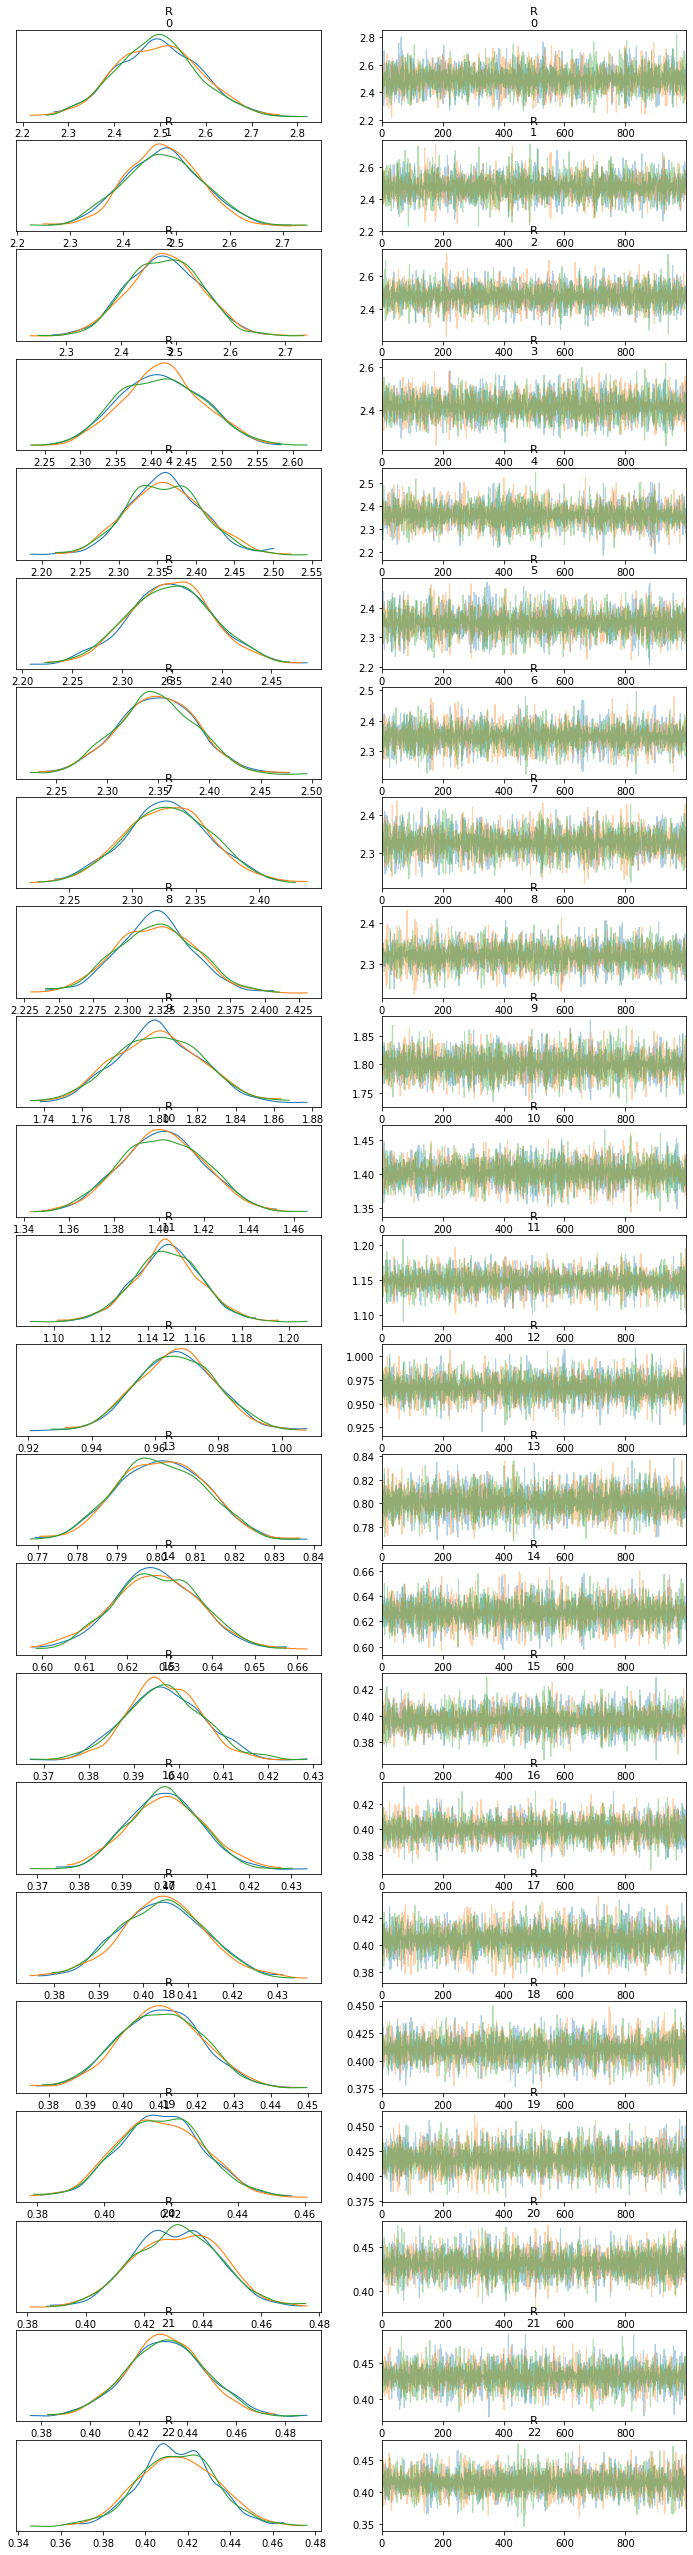

In [18]:
az.rcParams['plot.max_subplots'] = 2*(num_timepoints - R_t_start)

az.plot_trace(
    samples,
    var_names=('R'),
    filter_vars='like',
    compact=False)

In [19]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
chain_samples = fit._draws[7:, 500:, :]

# Evaluate the model for all parameter sets in the samples
n_param, n_sample, n_chains = chain_samples.shape

extended_samples = np.concatenate((
    chain_samples[:, :, 0],
    chain_samples[:, :, 1],
    chain_samples[:, :, 2]), axis=1)

thinning = max(1, int(n_sample * n_chains / 500))

N_pois_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': np.mean(extended_samples[:, ::thinning], axis=1)/N_corr,
    'Lower bound CI': np.quantile(extended_samples[:, ::thinning], 0.025, axis=1)/N_corr,
    'Upper bound CI': np.quantile(extended_samples[:, ::thinning], 0.975, axis=1)/N_corr,
    'Central Probability': (L1+L2) * [0.95]
})

T_pois_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': np.divide(np.mean(extended_samples[:, ::thinning], axis=1), T_corr),
    'Lower bound CI': np.divide(np.quantile(extended_samples[:, ::thinning], 0.025, axis=1), T_corr),
    'Upper bound CI': np.divide(np.quantile(extended_samples[:, ::thinning], 0.975, axis=1), T_corr),
    'Central Probability': (L1+L2) * [0.95]
})

### Aggregated data + Negative Binomial Branching process

In [20]:
negbin_model = """
functions {
    real normalizing_const (array [] real aSI) {
        return sum(aSI);
    }
    real effective_no_infectives (
        int N, int S, int t, array [] real aI, array [] real aSI) {
            real mean;
            if(t > S) {
                mean = (
                    dot_product(aI[(t-S):(t-1)], aSI) /
                    normalizing_const(aSI));
            }
            else {
                mean = (
                    dot_product(aI[:(t-1)], aSI[(S-t+2):]) /
                    normalizing_const(aSI));
            }
            return mean;
    }
}
data {
    int N; // number of days
    int S; // length serial interval
    array [N] int I; // local incidences for N days
    int tau; // sliding window
    array [S] real revSI; // reversed serial interval
    real a; // prior shape parameter
    real b; // prior rate parameter
    real phiShape; // prior shape parameter for phi
    real phiRate; // prior rate parameter for phi
}
parameters {
    array [N-tau-1] real<lower=0> R; // vector of R numbers
    real<lower=0> Phi; // overdispersion
}
model {
    for(t in (tau+1):(N-1)) {
        for(k in (t-tau+1):(t+1)) {
            if (effective_no_infectives(N, S, k, I, revSI) != 0) {
                I[k] ~ neg_binomial (1/Phi, 1/(Phi *
                    (R[t-tau] * effective_no_infectives(
                        N, S, k, I, revSI)))); // likelihood
            }
        }
    }
    for(t in 1:(N-tau-1)) {
        R[t] ~ gamma (a, b); // prior of R
    }
    Phi ~ gamma (phiShape, phiRate); // prior of Phi
}
"""

negbin_data = {
    'N': num_timepoints,
    'S': len(serial_interval),
    'I': agg_cases.astype(np.integer).tolist(),
    'tau': tau,
    'revSI': serial_interval.tolist()[::-1],
    'a': a,
    'b': b,
    'phiShape': phi_shape,
    'phiRate': phi_rate}

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_10465/2632923744.py:57: DeprecationWarning:

Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.



In [21]:
posterior = stan.build(
    negbin_model, data=negbin_data, random_seed=10)

fit = posterior.sample(
    num_chains=3, num_samples=1000)

samples = az.from_pystan(
    fit,
    observed_data='I',
    coords={'observation': list(range(num_timepoints)),
            'covariate': [
                '{}'.format(_)
                for _ in range(num_timepoints - R_t_start)]
            },
    dims={
        'I': ['observation'],
        'R': ['covariate']
        })

az.summary(samples)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/6000)
Sampling:   0% (2/6000)
Sampling:   0% (3/6000)
Sampling:   2% (102/6000)
Sampling:   3% (201/6000)
Sampling:   7% (400/6000)
Sampling:   8% (500/6000)
Sampling:  12% (700/6000)
Sampling:  13% (800/6000)
Sampling:  17% (1000/6000)
Sampling:  18% (1100/6000)
Sampling:  20% (1200/6000)
Sampling:  22% (1300/6000)
Sampling:  23% (1400/6000)
Sampling:  27% (1600/6000)
Sampling:  30% (1800/6000)
Sampling:  33% (2000/6000)
Sampling:  37% (2200/6000)
Sampling:  40% (2400/6000)
Sampling:  43% (2600/6000)
Sampling:  45% (2700/6000)
Sampling:  63% (3800/6000)
Sampling:  82% (4900/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient e

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
R[0],2.710,0.502,1.861,3.639,0.007,0.006,5458.0,2327.0,1.00
R[1],2.670,0.447,1.916,3.553,0.006,0.005,6308.0,2354.0,1.00
R[2],2.583,0.421,1.844,3.381,0.006,0.005,5316.0,2402.0,1.00
R[3],2.526,0.408,1.798,3.275,0.005,0.004,6839.0,2364.0,1.00
R[4],2.480,0.415,1.704,3.199,0.006,0.005,5993.0,1757.0,1.00
R[5],2.463,0.399,1.764,3.223,0.006,0.004,5948.0,2123.0,1.00
R[6],2.470,0.407,1.748,3.225,0.006,0.004,6509.0,2137.0,1.00
R[7],2.450,0.399,1.765,3.206,0.005,0.004,6700.0,2315.0,1.00
R[8],2.429,0.381,1.726,3.136,0.005,0.004,5821.0,2221.0,1.00
R[9],2.103,0.345,1.464,2.714,0.004,0.003,7103.0,2338.0,1.00


array([[<AxesSubplot:title={'center':'R\n0'}>,
        <AxesSubplot:title={'center':'R\n0'}>],
       [<AxesSubplot:title={'center':'R\n1'}>,
        <AxesSubplot:title={'center':'R\n1'}>],
       [<AxesSubplot:title={'center':'R\n2'}>,
        <AxesSubplot:title={'center':'R\n2'}>],
       [<AxesSubplot:title={'center':'R\n3'}>,
        <AxesSubplot:title={'center':'R\n3'}>],
       [<AxesSubplot:title={'center':'R\n4'}>,
        <AxesSubplot:title={'center':'R\n4'}>],
       [<AxesSubplot:title={'center':'R\n5'}>,
        <AxesSubplot:title={'center':'R\n5'}>],
       [<AxesSubplot:title={'center':'R\n6'}>,
        <AxesSubplot:title={'center':'R\n6'}>],
       [<AxesSubplot:title={'center':'R\n7'}>,
        <AxesSubplot:title={'center':'R\n7'}>],
       [<AxesSubplot:title={'center':'R\n8'}>,
        <AxesSubplot:title={'center':'R\n8'}>],
       [<AxesSubplot:title={'center':'R\n9'}>,
        <AxesSubplot:title={'center':'R\n9'}>],
       [<AxesSubplot:title={'center':'R\n10'}>,
  

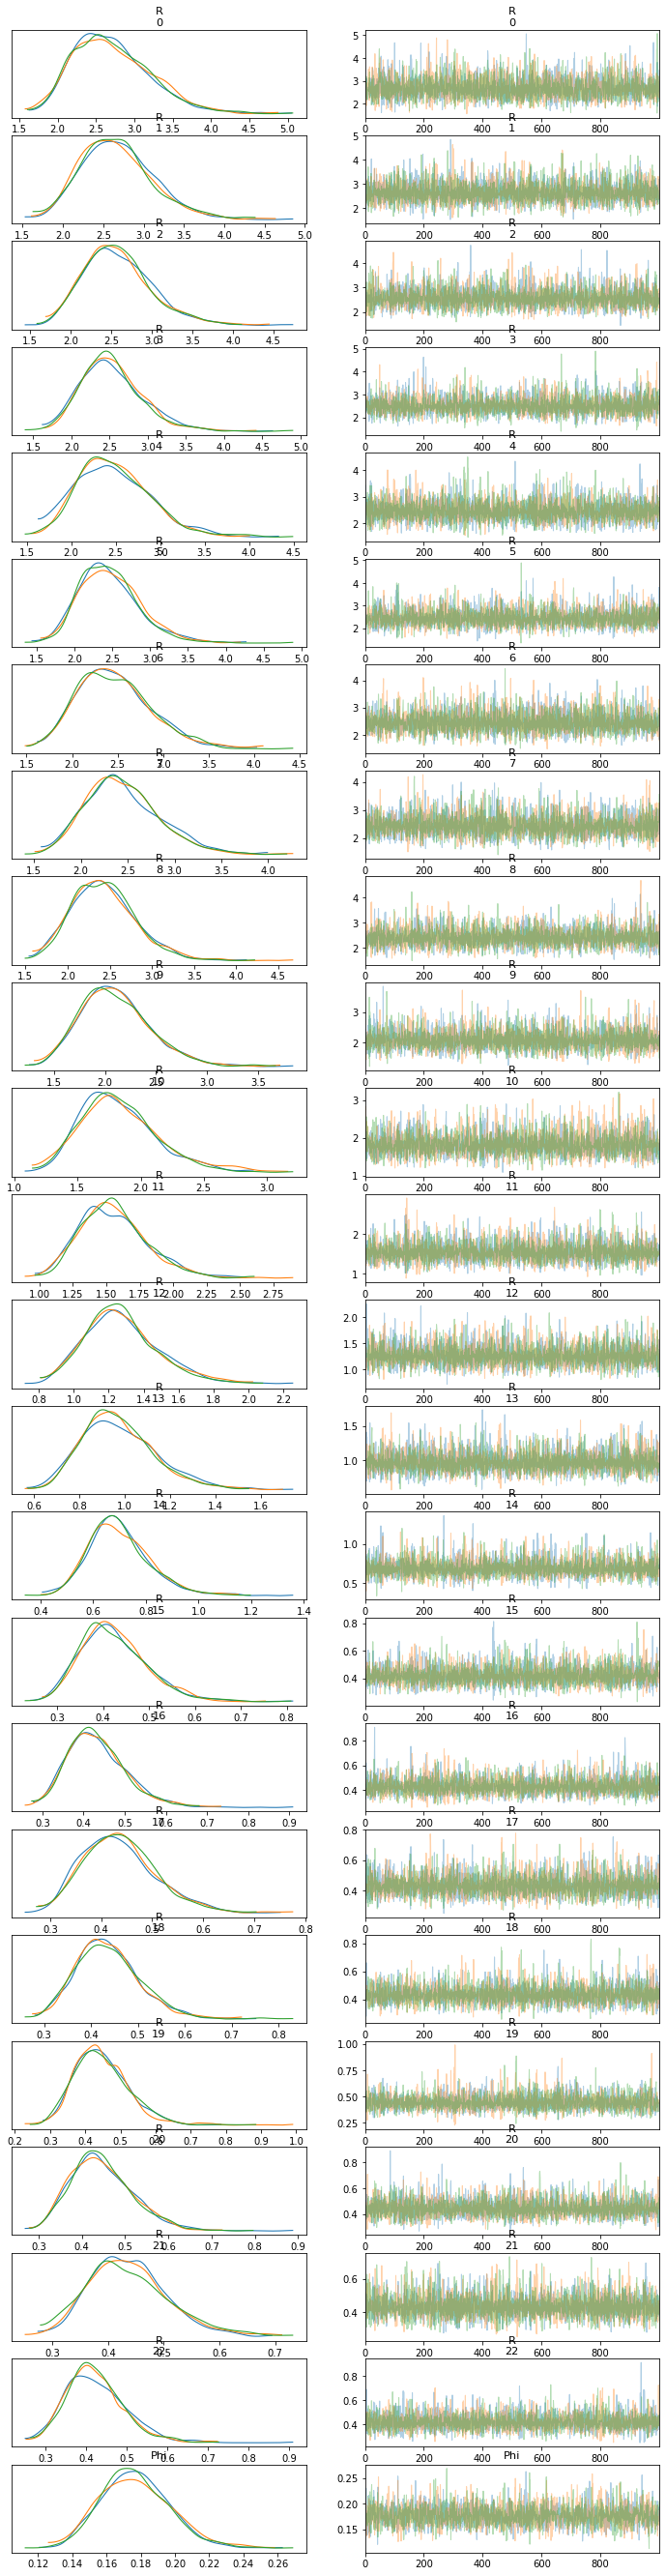

In [22]:
az.rcParams['plot.max_subplots'] = 2*(num_timepoints - R_t_start+1)

az.plot_trace(
    samples,
    var_names=('R', 'Phi'),
    filter_vars='like',
    compact=False)

In [23]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
chain_samples = fit._draws[7:-1, 500:, :]

# Evaluate the model for all parameter sets in the samples
n_param, n_sample, n_chains = chain_samples.shape

extended_samples = np.concatenate((
    chain_samples[:, :, 0],
    chain_samples[:, :, 1],
    chain_samples[:, :, 2]), axis=1)

thinning = max(1, int(n_sample * n_chains / 500))

N_negbin_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': np.mean(extended_samples[:, ::thinning], axis=1)/N_corr,
    'Lower bound CI': np.quantile(extended_samples[:, ::thinning], 0.025, axis=1)/N_corr,
    'Upper bound CI': np.quantile(extended_samples[:, ::thinning], 0.975, axis=1)/N_corr,
    'Central Probability': (L1+L2) * [0.95]
})

T_negbin_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': np.divide(np.mean(extended_samples[:, ::thinning], axis=1), T_corr),
    'Lower bound CI': np.divide(np.quantile(extended_samples[:, ::thinning], 0.025, axis=1), T_corr),
    'Upper bound CI': np.divide(np.quantile(extended_samples[:, ::thinning], 0.975, axis=1), T_corr),
    'Central Probability': (L1+L2) * [0.95]
})

## Inference plot using class method results

In [30]:
fig = ReproductionNumberPlot()

fig.add_ground_truth_rt(ground_truth)
fig.add_interval_rt(multicat_intervals, model_type='multi_categorical')
fig.add_interval_rt(agg_multicat_intervals, colour='orange', model_type='agg_multi_categorical')
fig.add_interval_rt(N_pois_intervals, colour='pink', shape='dash', model_type='poisson Naive correction term')
fig.add_interval_rt(T_pois_intervals, colour='red', model_type='poisson True correction term')
fig.add_interval_rt(N_negbin_intervals, colour='deepskyblue', shape='dash', model_type='negative_binomial Naive correction term')
fig.add_interval_rt(T_negbin_intervals, colour='blue', model_type='negative_binomial True correction term')

fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()